# Build knowledge graphs with LLM-driven entity extraction

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

Embeddings databases are a union of vector indexes (sparse and dense), graph networks and relational databases. This enables vector search with SQL, topic modeling, retrieval augmented generation and more.

Up until txtai 7.0, semantic graphs only supported automatic relationship detection. Now relationships can be loaded directly into a txtai database. This notebook will demonstrate how to work with this new feature.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[graph] autoawq

# Load Wikipedia database

The [txtai-wikipedia](https://huggingface.co/NeuML/txtai-wikipedia) database stores all Wikipedia article abstracts as of January 2024. This database is a great way to explore a wide variety of topics. It also has the number of page views integrated in, which enables pulling frequently viewed or popular articles on a topic.

For this example, we'll work with a couple articles related to `Viking raids in France`.

In [ ]:
from txtai import Embeddings

# Load dataset
wikipedia = Embeddings()
wikipedia.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

query = """
SELECT id, text FROM txtai WHERE similar('Viking raids in France') and percentile >= 0.5
"""

results = wikipedia.search(query, 5)

for x in results:
    print(x)

# LLM-driven entity extraction

Now that we have a couple relevant articles, let's go through and run an entity extraction process. For this task, we'll have a LLM prompt to do the work.

In [ ]:
import json

from txtai import LLM

# Load LLM
llm = LLM("TheBloke/Mistral-7B-OpenOrca-AWQ")

data = []
for result in results:
    prompt = f"""<|im_start|>system
    You are a friendly assistant. You answer questions from users.<|im_end|>
    <|im_start|>user
    Extract an entity relationship graph from the following text. Output as JSON

    Nodes must have label and type attributes. Edges must have source, target and relationship attributes.

    text: {result['text']} <|im_end|>
    <|im_start|>assistant
    """

    try:
        data.append(json.loads(llm(prompt, maxlength=4096)))
    except:
        pass

# Build an embeddings database

Now that we've extracted entities from the documents, next we'll review and load a graph network using these entity-relationships.

In [ ]:
def stream():
    nodes = {}

    for row in data.copy():
        # Create nodes
        for node in row["nodes"]:
            if node["label"] not in nodes:
                node["id"] = len(nodes)
                nodes[node["label"]] = node

        for edge in row["edges"]:
            source = nodes.get(edge["source"])
            target = nodes.get(edge["target"])

            if source and target:
                if "relationships" not in source:
                    source["relationships"] = []

                source["relationships"].append({"id": target["id"], "relationship": edge["relationship"]})

    return nodes.values()

# Create embeddings instance with a semantic graph
embeddings = Embeddings(
    autoid = "uuid5",
    path = "intfloat/e5-base",
    instructions = {
        "query": "query: ",
        "data": "passage: "
    },
    columns = {
        "text": "label"
    },
    content = True,
    graph = {
        "approximate": False,
        "topics": {}
    }
)

embeddings.index(stream())

# Show the network

Now let's visualize the entity-relationship network. This period might not be that familar to most, unless you've watched the Vikings TV series, in which case it should make sense.

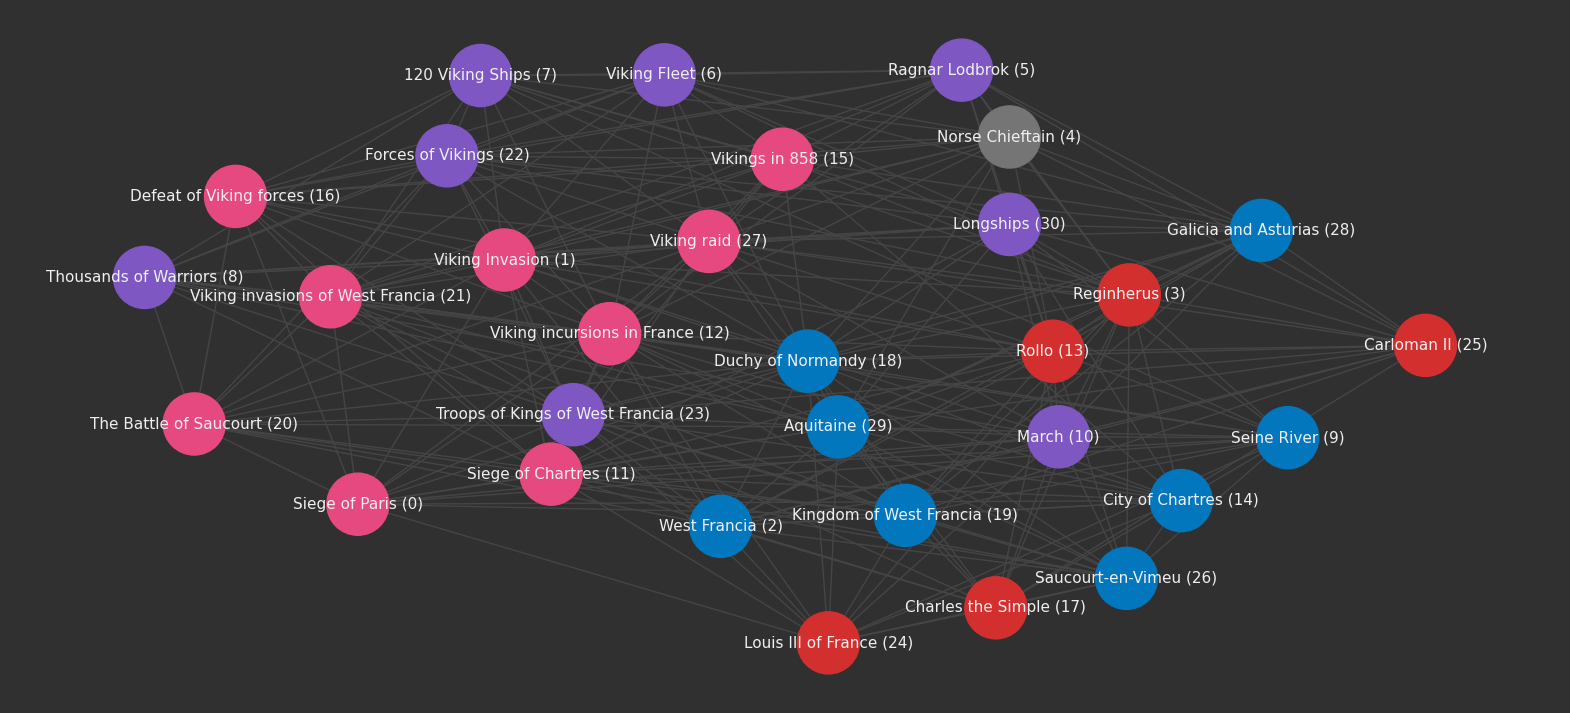

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'text')} ({x})" for x in graph.scan()}
    lookup = {
      "Person": "#d32f2f",
      "Location": "#0277bd",
      "Event": "#e64980",
      "Role": "#757575"
    }

    colors = []
    for x in graph.scan():
      value = embeddings.search("select type from txtai where id = :x", parameters={"x": x})[0]["type"]
      colors.append(lookup.get(value, "#7e57c2"))

    options = {
        "node_size": 2000,
        "node_color": colors,
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 11,
        "alpha": 1.0
    }

    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=3, iterations=250)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

plot(embeddings.graph)

# Graph traversal

The last thing we'll cover is extracting a specific path from the graph. Let's show a path from node 8 to node 5 requiring a specific relationship type to start.

A new feature of txtai 7.0 is the ability to return a graph of search results. This is a powerful addition as not only do we get the search results but we get how the search results relate to each other.

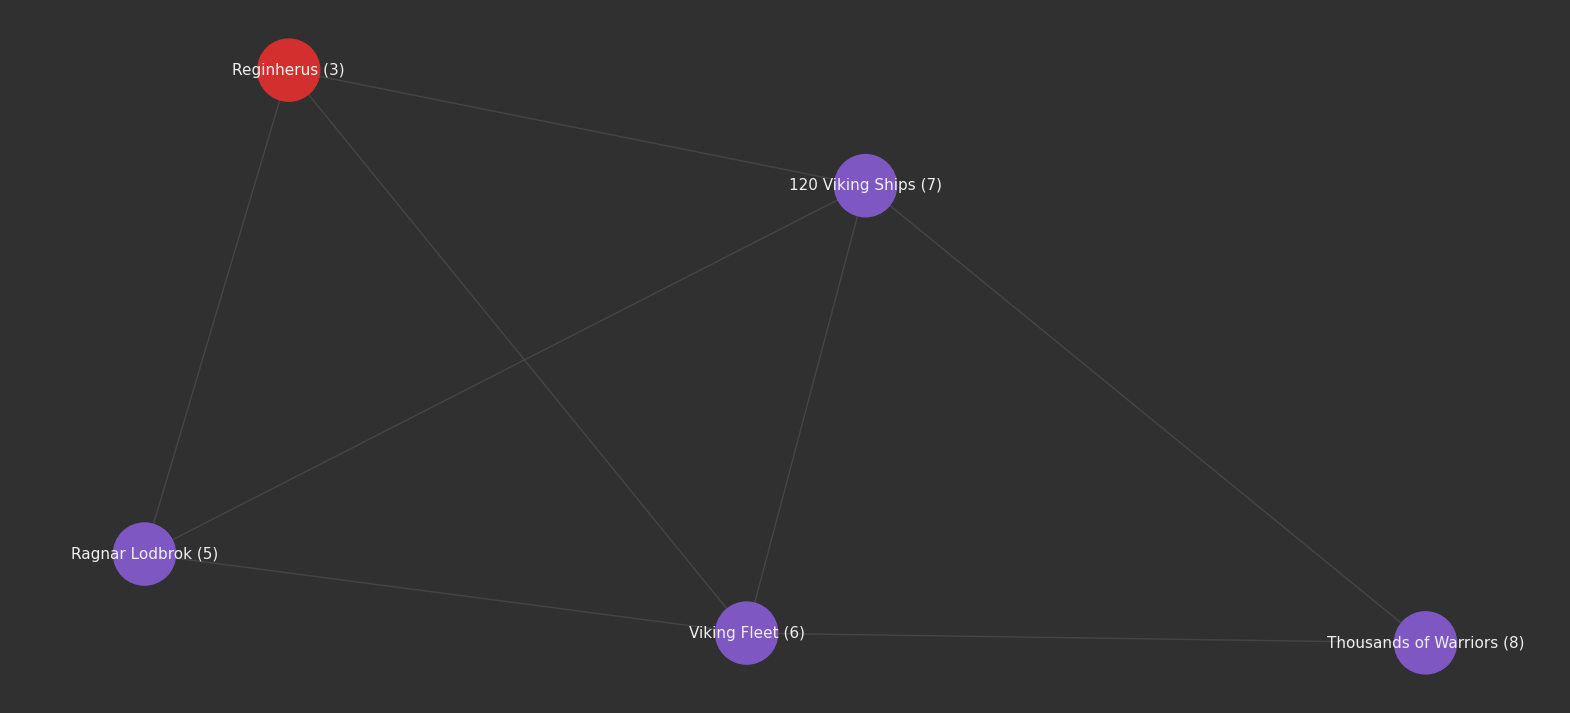

In [ ]:
# Traverse graph looking for certain nodes and edge values
g = embeddings.graph.search("""
  MATCH P=(A{id: 8})-[R1]->()-[*1..3]->(D{id:5})
  WHERE
    R1.relationship == "has_object"
  RETURN P
""", graph=True)

plot(g)

# Wrapping up

This notebook showed how knowledge graphs can be created with LLM-driven entity extraction. Automatically derived relationships via semantic similarity and manually specified ones are a powerful combination!